# Homework 4: Word Embeddings and Neural Language Models


Names: __Suzanne Becker, Yuval Timen__

Step 1: Word2Vec paper questions
---------------------------

### 1. Describe how a CBOW word embedding is generated.

A CBOW word embedding can be created by using the CBOW algorithm. This would consist of training a classifier to predict a target word given some context words. Specifically, given the sequence of length M $w_{0} ... w_{M}$ and a window size N, we would first create one-hot vectors for each word in the sequence. These will be used as inputs to the classifier. Then for each time step $t$, we will be trying to predict the word $w_{t}$ given the context words within the N-sized window. We take the N words from either side of $w_{t}$, namely $w_{t-N}...w_{t+N}$ excluding $w_{t}$. These will each be fed through the forward pass of the classifier, which will give an output vector of size 1xV, representing the probability distribution of predicting the next word over our entire vocabulary. The error for each iteration in training will be the sum of the errors for all context words. We do the backward propagation, and once the weights have been updated, we move to the next timestep and shift our target word to be the next word in the sequence ($w_{t+1}$), and repeat the training steps; for each timestep, we run the forward pass, find the error, and do backpropagation.

Once we complete training, our CBOW embeddings will be the weights we have learned. The weight matrix is of size VxE, where E is the size of the embeddings we want to learn. Thus we have V vectors each of length E, meaning that for each word in our vocabulary, we've created an embedding of length E.

### 2. What is a CBOW word embedding and how is it different from a skip-gram word embedding?

A CBOW word embedding is an embedding created using the CBOW algorithm - namely, embeddings learned by training a Neural Network to predict some target given some number of neighboring context words. This is very similar to the skip-gram method for generating word embeddings. The main difference is that, during the prediction task, CBOW tries to predict the target word given some neighboring context words, while skip-gram tries to predict the context words given a target word.

### 3. What is the task that the authors use to evaluate the generated word embeddings?

They tested that the word embeddings preserved the linear relationships between words; ideally, they wanted to have __vector("King") - vector("Man") + vector("Woman") = vector("Queen")__. They tested this by creating a large test set of 5 types of semtantic relationships and 9 types of syntactic questions. This was done by manually creating a list of word pairs, for example __(Athens, Greece)__ or __(great, greater)__. Then, each of these word pairs was connected to another word word pair in the same syntactic/semantic category, and the evaluation task consisted of seeing if the embeddings could accurately predict the second word in the second pair, given the relationship computed from the first pair. For example, given __(Athens, Greece)__ $\to$ __(Oslo, Norway)__, they computed the vectors for each of the first 3 words, did the vector math, and saw whether the result was the correct last word: __vector(Athens) - vector(Greece) + vector(Oslo) =? vector(Norway)__.

### 4. What are PCA and t-SNE? Why are these important to the task of training and interpreting word embeddings?

PCA (or Principal Component Analysis) is a method of finding the set of dimensions in a vector space which maximizes the variance in each dimension. This is done by taking linear combinations of our other features to try to find the first PC dimension which maximizes the variance of our data. Then, each subsequent PCA dimension is calculated using the same method, with the added condition that the new dimension must be orthogonal to all other PC dimensions. This effectively is a way of projecting the data from $\mathbb{R}^{N} \to \mathbb{R}^{N}$, where the new vector space's axes are sorted in order of "importance" or information. To use PCA to visualize word embeddings, we can run PCA on our embedding space, and then take the first 2 or 3 PCA dimensions and use them to visualize our embeddings in a 2 or 3 dimensional space.

On the other hand, t-SNE is a method for visualizing high-dimensional data while also trying to avoid the "curse of dimensionality". When our data lives in high-dimensional vector spaces, simply projecting the space onto a 2 or 3 dimensional plane will cause our data to overcrowd. This makes it very hard to see clusters or any other meaningful relationship between the data. t-SNE solves this problem by modeling the distribution of points in the high-dimensional space, and then re-creating that distribution in a lower dimensional space. The points in 2-d are sampled according to the distribution, meaning that the user of t-SNE gets to control how many points are sampled. This will avoid the overcrowding problem and will still allow us to visualize our high-dimensional data.

PCA and t-SNE are important in training and interpreting word embeddings because they provide a human-interpretable view on generated vector embeddings, which are otherwise long lists of numbers with no inherent semantic meaning to the human eye. Projecting vector embeddings into smaller-dimensional space would potentially reveal clusters in 2 or 3 dimensions which will allow us to visually inspect the quality of our embeddings: does each cluster contain words that we as humans would consider "similar"?

Step 2: Train your own word embeddings
--------------------------------

# The Spooky Author Dataset

We first examine the aptly named Spooky Authors dataset. This is a compilation of works from Edgar Allan Poe, H.P. Lovecraft, and Mary Shelley, and can be accessed on Kaggle [here](https://www.kaggle.com/c/spooky-author-identification/overview). 

# Our Dataset: [insert]

__Describe what data set you have chosen to compare and contrast with the Spooky Authors Dataset. Make sure to describe where it comes from and it's general properties.__

__(describe your dataset here)__

In [1]:
# Imports
import csv
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
from MulticoreTSNE import MulticoreTSNE as TSNE

%matplotlib inline
%load_ext wurlitzer

# Some constants
EMBEDDINGS_SIZE = 300
SPOOKY_DATA_PATH_TEST = "./data_files/spooky_test.csv"
SPOOKY_DATA_PATH_TRAIN = "./data_files/spooky_train.csv"

In [2]:
# Read in the data
with open(SPOOKY_DATA_PATH_TRAIN, newline='') as f:
    reader = csv.reader(f)
    reader.__next__()  # skip the column names 
    train = [row[1] for row in reader]  # Take only the text data
    
with open(SPOOKY_DATA_PATH_TEST, newline='') as f:
    reader = csv.reader(f)
    reader.__next__()  # skip the column names
    test = [row[1] for row in reader]  # Take only the text data
    
# Use all the data
sentences_spooky = train + test

Data Pre-processing
--------------------------------

We clean and organize our data into a list-of-list-of strings. Each nested list represents a sentence. 
For data cleaning, we first change the entire corpus to lowercase.
Next, we remove all punctuation and numbers, replacing them with a whitespace.
We then compile all the sentences into a single list. Finally, we split each sentence into a list of words. 

In [3]:
# Data pre-processing/cleaning

# Lowercases all words, removes punctuation, 
# and replaces all instances of a number with NUMBER_TOKEN
def clean_data(sentences):
    regex_punctuation = r'[.,;:/\\\(\)\[\]!?<>]'
    regex_numbers = r'[0-9]'
    
    output = []
    
    for sent in sentences:
        tmp = sent.lower()
        tmp = re.sub(regex_punctuation, ' ', tmp)
        tmp = re.sub(regex_numbers, ' ', tmp)
        output.append(tmp)
    
    return output

sentences_spooky = clean_data(sentences_spooky)
sentences_listed_spooky = [sentence.split() for sentence in sentences_spooky]

Data Exploration & Statistics
----------------------------------

We 

In [4]:
# Data exploration

# Prints some basic statistics about our dataset:
# 1. Total Number of Sentences
# 2. Average Sentence Length in Words
# 3. Total Number of Words
# 4. Average Word Length in Characters
# 5. Vocabulary Size
# (The function returns the list of all words in the dataset)
def print_dataset_statistics(sentences):
    num_sentences = len(sentences)
    avg_sent_length = np.mean([len(sent.split()) for sent in sentences])
    all_words = []
    for sent in sentences:
        all_words.extend(sent.split())
    avg_word_length = np.mean([len(word) for word in all_words])
    num_words = len(all_words)
    vocab_size = len(set(all_words))
    
    print(f"Total sentences: {num_sentences}")
    print(f"Average sentence length: {round(avg_sent_length, 3)} words")
    print(f"Total number of words: {num_words}")
    print(f"Average word length {round(avg_word_length, 3)} characters")
    print(f"Vocabulary size: {vocab_size}")
    
    return all_words


all_words_spooky = print_dataset_statistics(sentences_spooky)

Total sentences: 27971
Average sentence length: 26.728 words
Total number of words: 747619
Average word length 4.479 characters
Vocabulary size: 30724


### a) Train embedding on GIVEN dataset

In [5]:
# Create the embeddings, save the KeyedVector, toss the model
model_spooky = Word2Vec(sentences=sentences_listed_spooky, size=EMBEDDINGS_SIZE, sg=1, window=5, min_count=1)
# model_philo = Word2Vec(sentences=sentences_listed_philo, size=EMBEDDINGS_SIZE, sg=1, window=5, min_count=1)
spooky_embeddings = model_spooky.wv
# philo_embeddings = model_philo.wv
del model_spooky
# del model_philo

In [6]:
# This function prints some quick similarities and comparisons for the given embeddings
def quick_evaluate_embeddings(embeddings):
    
    similar_to_king = spooky_embeddings.most_similar('king')[0][0]
    similar_to_horse = spooky_embeddings.most_similar('horse')[0][0]
    similar_to_man = spooky_embeddings.most_similar('man')[0][0]
    king_minus_man_plus_woman = spooky_embeddings.most_similar(positive=['king', 'woman'], negative=['man'])[0][0]
    odd_one_out_food = spooky_embeddings.doesnt_match(('bread', 'meat', 'vegetables', 'peasant'))
    odd_one_out_days = spooky_embeddings.doesnt_match(('monday', 'wednesday', 'friday', 'favorite'))
    odd_one_out_animals = spooky_embeddings.doesnt_match(('cat', 'dog', 'sheep', 'wolf', 'hose'))

    print(f"Word most similar to 'king': {similar_to_king}")
    print(f"Word most similar to 'horse': {similar_to_horse}")
    print(f"Word most similar to 'man': {similar_to_man}")
    print(f"King - Man + Woman: {king_minus_man_plus_woman}")
    print(f"Was the model able to distinguish 'peasant' from food? {odd_one_out_food is 'peasant'}")
    print(f"Was the model able to distinguish 'favorite' from weekdays? {odd_one_out_days is 'favorite'}")
    print(f"Was the model able to distinguish 'hose' from animals? {odd_one_out_animals is 'hose'}")
    

print('Output for Spooky Embeddings:')
quick_evaluate_embeddings(spooky_embeddings)
print('--------------------------------------')
print('Output for Philosophical Embeddings')
# quick_evaluate_embeddings(philo_embeddings)

Output for Spooky Embeddings:
Word most similar to 'king': title
Word most similar to 'horse': erect
Word most similar to 'man': woman
King - Man + Woman: princess
Was the model able to distinguish 'peasant' from food? True
Was the model able to distinguish 'favorite' from weekdays? True
Was the model able to distinguish 'hose' from animals? False
--------------------------------------
Output for Philosophical Embeddings


/usr/local/lib/python3.7/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


In [19]:
# Building the t-SNE projection

# This is the V x E matrix; the full-length embedding for each vocab word
# Each unique word $w_{i}$ represents the row $V_{i}$
# Each row is a vector of length E which corresponds to that word's embedding 
X_spooky = spooky_embeddings[spooky_embeddings.vocab]
# X_philo = philo_embeddings[philo_embeddings.vocab]
print(f"Original shape of the matrix: {X_spooky.shape}")  # (31851, 300)


# We first run PCA and keep the first num_components dimensions before we pass into t-SNE
num_components = 50
random_seed = 100

pca = PCA(n_components=num_components)
X_spooky = pca.fit_transform(X_spooky)
print(f"New shape of the matrix: {X_spooky.shape}")  # (31851, 50)

# Since we ran PCA and kept only the first few dimensions, we want to know how much
# of the original information is still preserved in this projection. The concept of
# "explained variance" is helpful here. Our original 300-dimensional vector space has 
# a certain amount of variance among the data. This is our "total variance". When we 
# project to 50 dimensions, we lose some of that variance, since we lose dimensions along
# which our data can vary. We calculate the total amount of variance in our 50-dimensional
# space and divide that number by our total variance. This yields the amount of variance 
# preserved after our projection. So while our data might not have *all* of the original
# variance, we can still see that it has a significant percentage of the total variance, and
# so we only lose a small amount of information while reducing our space a lot. Thanks PCA!
print(f"Cumulative explained variance of first {num_components} PC dimensions: {100 * round(np.sum(pca.explained_variance_ratio_), 3)}%")


# Now we run t-SNE to visualize the clusters
tsne_spooky = TSNE(n_components=2, perplexity=45, verbose=True, random_state=random_seed, n_iter=500)
# tsne_philo = TSNE(n_components=2, perplexity=45, verbose=True, random_state=random_seed, n_iter=500)
X_embedded_spooky = tsne_spooky.fit_transform(X_spooky)
# X_embedded_philo = tsne.fit_transform(X_philo)

Original shape of the matrix: (30724, 300)
Cumulative explained variance of first 50 PC dimensions: 99.19999837875366%


Performing t-SNE using 1 cores.
Using no_dims = 2, perplexity = 45.000000, and theta = 0.500000
Computing input similarities...
Building tree...
 - point 3072 of 30724
 - point 6144 of 30724
 - point 9216 of 30724
 - point 12288 of 30724
 - point 15360 of 30724
 - point 18432 of 30724
 - point 21504 of 30724
 - point 24576 of 30724
 - point 27648 of 30724
 - point 30720 of 30724
Done in 19.00 seconds (sparsity = 0.006987)!
Learning embedding...
Iteration 51: error is 103.797631 (50 iterations in 15.00 seconds)
Iteration 101: error is 95.830847 (50 iterations in 16.00 seconds)
Iteration 151: error is 90.900840 (50 iterations in 14.00 seconds)
Iteration 201: error is 89.940519 (50 iterations in 12.00 seconds)
Iteration 251: error is 89.699723 (50 iterations in 13.00 seconds)
Iteration 301: error is 3.903670 (50 iterations in 13.00 seconds)
Iteration 351: error is 3.634299 (50 iterations in 12.00 seconds)
Iteration 401: error is 3.478258 (50 iterations in 12.00 seconds)
Iteration 451: err

[16. 10.]


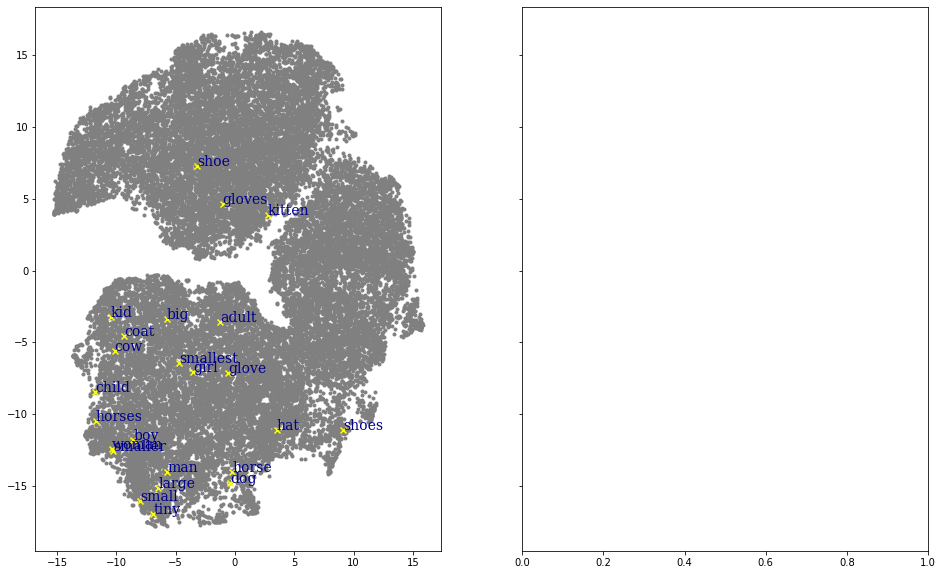

In [20]:
# Visualizing the data

vis_x_spooky = X_embedded_spooky[:, 0]
vis_y_spooky = X_embedded_spooky[:, 1]

# vis_x_philo = X_embedded_philo[:, 0]
# vis_y_philo = X_embedded_philo[:, 1]

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16, 10))

print(fig.get_size_inches())

ax1.scatter(vis_x_spooky, vis_y_spooky, c='grey', marker='.')
# ax.scatter(vis_x_philo, vis_y_philo, c='blue', marker='.')

# We highlight the location of several words of interest on this chart.
words_of_interest = ('man', 'woman', 'boy', 'girl', 'child', 'kid', 'adult',
                     'coat', 'hat', 'shoe', 'shoes', 'glove', 'gloves',
                     'dog', 'kitten', 'horse', 'horses', 'cow',
                     'large', 'big', 'tiny', 'small', 'smaller', 'smallest')
vectors_of_interest = []
# Need to look up the index of the word to find its corresponding t-SNE vector
for word in words_of_interest:
    idx_of_word = spooky_embeddings.vocab[word].index
    vectors_of_interest.append(tsne_spooky.embedding_[idx_of_word])
    
# Text styling parameters
font= {'family':'serif','color':'darkblue','weight':'normal','size':14}

# Draw the words of interest on and label them 
for idx, vec in enumerate(vectors_of_interest):
    ax1.scatter(vec[0], vec[1], c='yellow', marker='x')
    ax1.text(vec[0], vec[1], words_of_interest[idx], fontdict=font)

plt.show()

What text-normalization and pre-processing did you do and why? __YOUR ANSWER HERE__

Step 3: Evaluate the differences between the word embeddings
----------------------------

(make sure to include graphs, figures, and paragraphs with full sentences)

Cite your sources:
-------------

Step 4: Feedforward Neural Language Model
--------------------------

### a) First, encode  your text into integers

In [9]:
# Importing utility functions from Keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Embedding

NGRAM = 4  # The size of the ngram language model you want to train

NameError: name 'data' is not defined

In [ ]:
# First, we map each word to a unique index
def to_unique_id(all_words):
    uniques = set(all_words)
    return {word: idx for idx, word in enumerate(uniques)}
    

indexed_spooky = to_unique_id(all_words_spooky)


### b) Next, prepare your sequences from text

#### Fixed ngram based sequences (Used for Feedforward)

In [ ]:
def generate_ngram_training_samples():
    '''
    Takes the encoded data (list of lists) and generates the training samples 
    out of it.
    Parameters:
    up to you!
    return: list of lists in the format [[x1, x2, ... , x(n-1), y], ...]
    '''
    pass


### c) Then, split the sequences into X and y and create a Data Generator

In [ ]:
# Note here that the sequences were in the form: 
# sequence = [x1, x2, ... , x(n-1), y]
# We still need to separate it into [[x1, x2, ... , x(n-1)], ...], [y1, y2, ...]

In [ ]:
def read_embeddings():
    '''Loads and parses embeddings trained in earlier.'''
    
    # you may find generating the following two dicts useful:
    # word to embedding : {'the':1, ...}
    # index to embedding : {1:'the', ...} (inverse of word_2_embedding)
    pass


# remember that "0" index is assigned for padding token. 
# Hence, initialize the vector for padding token as all zeros of embedding size

In [ ]:
def data_generator(X, y, num_sequences_per_batch):
    '''
    Returns data generator to be used by feed_forward
    https://wiki.python.org/moin/Generators
    https://realpython.com/introduction-to-python-generators/
    
    Yields batches of embeddings and labels to go with them.
    Use one hot vectors to encode the labels (see the to_categorical function)
    
    '''
    pass



In [ ]:
# Examples
# initialize data_generator
# num_sequences_per_batch = 1024 # or Batch Size
# steps_per_epoch = len(sequences)//num_sequences_per_batch  # Number of batches per epoch
# train_generator = data_generator(X, y, num_sequences_per_batch)

# sample=next(train_generator) # this is how you get data out of generators
# sample[0].shape # (batch_size, (n-1)*EMBEDDING_SIZE)

### d) Train your models

In [ ]:
# code to train a feedforward neural language model 
# on a set of given word embeddings
# make sure not to just copy + paste to train your two 

# Defining the model architecture using Keras Sequential API


In [ ]:
# Start training the model
model.fit_generator(train_generator, 
                    steps_per_epoch=steps_per_epoch,
                    epochs=1)

### e) Generate Sentences

In [ ]:
# generate a sequence from the model
def generate_seq(model, tokenizer, seed, n_words):
    '''
    Parameters:
        model: your neural network
        tokenizer: the keras preprocessing tokenizer
        seed: [w1, w2, w(n-1)]
        n_words: generate a sentence of length n_words
    Returns: string sentence
    '''
    pass

### f) Compare your generated sentences

Sources Cited
----------------------------
